<a href="https://colab.research.google.com/github/FatimaElsaadny/Head_pose-Detection/blob/main/PoseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install mediapipe

In [2]:
import numpy as np
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin
import dlib
import glob
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFilter
import mediapipe
from google.colab.patches import cv2_imshow

In [3]:
predictor=dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/Face_pose_detection/facial-landmarks/shape_predictor_68_face_landmarks.dat')
cnn_face_detector = dlib.get_frontal_face_detector()


In [4]:
FOLDER_PATH = "/content/drive/MyDrive/Colab Notebooks/Face_pose_detection/facial-landmarks/AFLW2000"

In [5]:
def imgs_in_both_formats(folder_path):
  """
    there is some images that has .mat and don't have .jpg and vise versa, 
    so the goal of this function is found the images that has both mat, jpg

    Input  : Folder path 
    Output : list of images that has both formats
  """
  all_jpg_img = [Path(f).stem for f in glob.glob(folder_path+"/*.jpg")]
  all_mat_img = [Path(f).stem for f in glob.glob(folder_path+"/*.mat")]
  exist_img = [ img for img in all_mat_img if img in all_jpg_img]

  print(f"No. of .jpg images = {len(all_jpg_img)}")
  print(f"No. of .mat images = {len(all_mat_img)}")
  print(f"No. of images that have both formats = {len(exist_img)}")

  return exist_img

exist_img = imgs_in_both_formats(FOLDER_PATH)

No. of .jpg images = 1314
No. of .mat images = 1308
No. of images that have both formats = 1304


# Extract 468-face-landMarks using mediapipe

In [6]:
def extract_land_marks(abs_path= None, relative_path= None, img= None):
  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  x_list = []
  y_list = []
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      image = None
      # loading the image
          
      if abs_path != None:
        image = cv2.imread(abs_path)
      elif relative_path != None:
        image = cv2.imread(FOLDER_PATH +'/'+ relative_path +'.jpg')
      else:
        image = img

      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                x_list.append(x)
                y_list.append(y)
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
        #         cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
        # cv2_imshow(image)
  return  x_list, y_list

In [7]:
extract_land_marks(relative_path="image00006")

([0.3177971839904785,
  0.3213275969028473,
  0.3183157444000244,
  0.31106358766555786,
  0.32145899534225464,
  0.3203529119491577,
  0.3163532614707947,
  0.24719321727752686,
  0.3146744668483734,
  0.3145008087158203,
  0.31206971406936646,
  0.3175475001335144,
  0.317069411277771,
  0.3164122402667999,
  0.31628915667533875,
  0.31661778688430786,
  0.3167141079902649,
  0.316653847694397,
  0.31608739495277405,
  0.32050737738609314,
  0.31022483110427856,
  0.2069675624370575,
  0.27496787905693054,
  0.2660735249519348,
  0.25679710507392883,
  0.2429986596107483,
  0.2821022570133209,
  0.26065367460250854,
  0.2705897390842438,
  0.2513903081417084,
  0.24503347277641296,
  0.23551017045974731,
  0.2816161513328552,
  0.2428865283727646,
  0.2031141072511673,
  0.22373346984386444,
  0.2686869502067566,
  0.3051553964614868,
  0.30607542395591736,
  0.29203689098358154,
  0.28360018134117126,
  0.29660066962242126,
  0.28934377431869507,
  0.2712770104408264,
  0.3135677278

# Extract all 468-face-landMarks from all images and creat dataframe from these features

In [8]:
def reshaping(x, y):

  x=np.array(x)
  x=x.reshape(1,-1)

  y=np.array(y)
  y=y.reshape(1,-1)

  row = np.concatenate( (x, y), axis= 1)

  return row

In [9]:
def build_featuresDF(all_jpg_img):
  all_data = []
  valid_img = []
  for img in all_jpg_img:
        
    # print(img)
    x_list, y_list = extract_land_marks(relative_path=img)
    # print(f"length of x= {len(x_list)},  length of y= {len(y_list)}")

    if (len(x_list) != 0) or ( len(y_list) != 0) :

      valid_img.append(img)

      row = reshaping(x_list, y_list)
  
      all_data.append(row)
      # print(row.shape)

  data = np.array(all_data, dtype= np.float32)

  data=data.reshape(-1,468*2)

  df = pd.DataFrame(data)
  # df.add(row , axis= 0)
  return df, valid_img
  

In [10]:
df, valid_img = build_featuresDF(exist_img)

In [11]:
df.shape

(1215, 936)

In [12]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.546091,0.587954,0.548542,0.564166,0.594339,0.588436,0.562385,0.401249,0.561440,0.569095,...,0.620113,0.612512,0.623434,0.622892,0.626574,0.479306,0.486759,0.493056,0.466905,0.459129
1,0.468223,0.420989,0.461647,0.423274,0.414745,0.420752,0.446074,0.418327,0.445505,0.437089,...,0.607283,0.599860,0.601858,0.610119,0.612023,0.458667,0.469096,0.477510,0.425301,0.412821
2,0.516563,0.543580,0.529391,0.536605,0.549872,0.553888,0.559656,0.397423,0.570571,0.578028,...,0.622500,0.618901,0.639634,0.623211,0.627510,0.519228,0.520320,0.520866,0.537556,0.531444
3,0.474219,0.458108,0.474031,0.459786,0.457981,0.463919,0.483806,0.408547,0.488981,0.488675,...,0.600177,0.594735,0.606618,0.601219,0.605522,0.496656,0.500780,0.503165,0.497452,0.492441
4,0.504645,0.542752,0.519815,0.526106,0.547868,0.547330,0.538348,0.372877,0.539666,0.544221,...,0.633404,0.626858,0.628772,0.636434,0.637854,0.491542,0.498362,0.504508,0.478643,0.472745


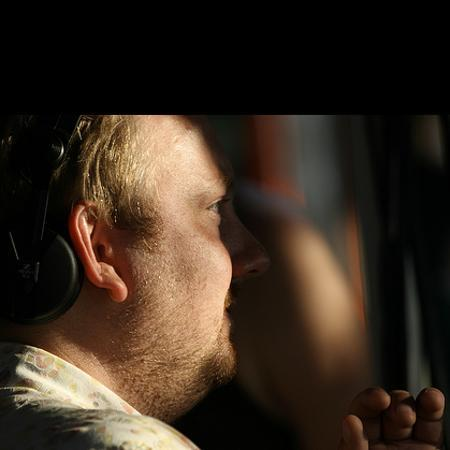

In [13]:
image = cv2.imread(FOLDER_PATH +'/'+ "image00392" +'.jpg')
cv2_imshow(image)

# Save Data in csv

In [14]:
df.to_csv("data468point",index=False) #save to file

#Then, to reload:
df = pd.read_csv("data468point")

In [15]:
df = pd.read_csv("/content/data468point")

In [16]:
df.shape

(1215, 936)

# Extarct all batch, Roll, Yaw for only valid images

In [17]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(FOLDER_PATH +'/'+ mat_path +'.mat')
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]

    # And convert to degrees.
    pitch = pose_params[0] * 180 / np.pi
    yaw = pose_params[1] * 180 / np.pi
    roll = pose_params[2] * 180 / np.pi

    bins = np.array(range(-99, 102, 3))
    labels =np.digitize([roll, yaw, pitch,], bins) - 1
    cont_labels = [roll, yaw, pitch,]

    return cont_labels #roll, yaw, pitch

In [18]:
def save_labels_toDF(valid_img):
  all_labels = []
  for img in valid_img:
    cont_labels = get_ypr_from_mat(img)
    cont_labels = np.array(cont_labels, dtype=np.float32)
    cont_labels = cont_labels.reshape(1,-1)

    all_labels.append(cont_labels)

  
  data = np.array(all_labels, dtype= np.float32)

  data = data.reshape(-1,3)

  df = pd.DataFrame(data = data, columns= ['roll', 'yaw', 'pitch'])

  return df


In [19]:
labelDF = save_labels_toDF(valid_img)

In [20]:
labelDF.shape

(1215, 3)

In [21]:
labelDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   roll    1215 non-null   float32
 1   yaw     1215 non-null   float32
 2   pitch   1215 non-null   float32
dtypes: float32(3)
memory usage: 14.4 KB


# Save Labels to csv

In [22]:
labelDF.to_csv("ypr_label",index=False) #save to file

df2 = pd.read_csv("/content/ypr_label")
df2.head()

,roll,yaw,pitch
0,16.687817,-45.529613,-9.114935
1,-28.236662,54.037780,-19.473500
2,14.065581,-13.100798,-0.834398
3,2.965735,18.250540,8.314507
4,10.634406,-19.357767,-18.066013


In [23]:
df2 = pd.read_csv("/content/ypr_label")
df2.head()

,roll,yaw,pitch
0,16.687817,-45.529613,-9.114935
1,-28.236662,54.037780,-19.473500
2,14.065581,-13.100798,-0.834398
3,2.965735,18.250540,8.314507
4,10.634406,-19.357767,-18.066013


## concat features with labels in a on DF then save them in csv

In [ ]:
df3 = df.join(df2)
df3.head()

In [ ]:
df3.to_csv("all_data",index=False) #save to file

# Read all data from csv

In [ ]:
df4 = pd.read_csv("/content/all_data")
df4.head()

In [ ]:
cont_labels = get_ypr_from_mat(valid_img[50])

In [ ]:
np.shape(cont_labels)

# Drawing

In [24]:
def draw_axis(roll, yaw, pitch, tdx=None, tdy=None, size = 100, abs_path=None, relative_path=None, img=None):



    img = None
    # loading the image
    if abs_path != None:
      img = cv2.imread(abs_path)
    else:
      img = cv2.imread(FOLDER_PATH +'/'+ relative_path +'.jpg')
    
    
    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [25]:
cv2_imshow(draw_axis( roll, yaw, pitch, relative_path=valid_img[50]))

NameError: ignored

In [ ]:
def x( roll, yaw, pitch, abs_path= None, relative_path= None):


  # loading the image
  frame = None
  
  if abs_path != None:
    frame = cv2.imread(abs_path)

  else:
    frame = cv2.imread(FOLDER_PATH +'/'+ relative_path +'.jpg')


  cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

  dets = cnn_face_detector(cv2_frame, 1)
  out_img = None
  for (idx, det) in enumerate(dets):
              # Get x_min, y_min, x_max, y_max, conf
              x_min = det.left()
              y_min = det.top()
              x_max = det.right()-x_min
              y_max = det.bottom()-y_min
              # conf = det.confidence
              # print(det)

              shape = predictor(cv2_frame, det)
              tdx,tdy=shape.part(30).x, shape.part(30).y
              bbox_height, bbox_width = frame.shape[:2]
            
              cv2.destroyAllWindows()

             
              # loading the image
              if abs_path != None:
                out_img = draw_axis(roll, yaw, pitch, tdx=tdx, tdy=tdy, size = 100, abs_path=abs_path, relative_path=None)
              elif relative_path != None:
                out_img = draw_axis(roll, yaw, pitch, tdx=tdx, tdy=tdy, size = 100, abs_path=None, relative_path=relative_path)
             

              # cv2_imshow(draw_axis(img,-5.620685,-4.7939262 ,2.5846152,tdx,tdy)
            
              # cv2_imshow(out_img)
              
  cv2.destroyAllWindows()
  return out_img


In [ ]:
roll, yaw, pitch

In [ ]:
roll, yaw, pitch = get_ypr_from_mat(valid_img[50])
y = x(roll, yaw, pitch, relative_path=valid_img[50])

# Data preprocessing for training

In [32]:
X_points = np.array(df.iloc[:, 0:468])
Y_points = np.array(df.iloc[:, 468:] )

# center 99
# max = 10
# min = 171
# centering the data arround the 99th point 
Center_X = X_points - X_points[:,99].reshape(-1, 1)
Center_Y = Y_points - Y_points[:,99].reshape(-1, 1)

# normalizing the data to be in the same scale by dividing over the distance between point 10 and point 171
X_171 = X_points[:,171]
X_10 = X_points[:,10]
Y_171 = Y_points[:,171]
Y_10 = Y_points[:,10]
# computing the distance
distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
Norm_X = Center_X / distance
Norm_Y = Center_Y / distance

# if you want to choose specific columns from the data
Final_X = Norm_X
Final_Y = Norm_Y

print(Final_X.shape)
print(Final_Y.shape)

# concatinating the X and Y points to form the compelete features
features = np.hstack([Final_X,Final_Y])
print(features.shape)


(1215, 468)
(1215, 468)
(1215, 936)


In [33]:
df = pd.DataFrame(features)

In [34]:
import pickle
with open('normalized_data_for_training.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Create models

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df, df2, test_size= 0.2, random_state= 42, shuffle= True)

# Regression Model

In [50]:
class RegressionModel():

  def __init__(self, X_train, X_test, y_train, y_test, images= None):

    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test
    self.valid_img = images

    self.yaw_pred = None
    self.roll_pred = None
    self.pitch_pred = None

    self.yaw_mode = LinearRegression()
    self.roll_mode = LinearRegression()
    self.pitch_mode = LinearRegression()

  def fitModel(self):

    self.yaw_mode.fit(self.X_train, self.y_train.yaw)

    self.roll_mode.fit(self.X_train, self.y_train.roll)

    self.pitch_mode.fit(self.X_train, self.y_train.pitch)

  def predict(self, X_test= None):

    if X_test != None:
      self.yaw_pred   = self.yaw_mode.predict(X_test)

      self.roll_pred  = self.roll_mode.predict(X_test)

      self.pitch_pred = self.pitch_mode.predict(X_test)

    else:

      self.yaw_pred   = self.yaw_mode.predict(self.X_test)

      self.roll_pred  = self.roll_mode.predict(self.X_test)

      self.pitch_pred = self.pitch_mode.predict(self.X_test)



  def r2_scor(self):

    re2_yaw  = r2_score( self.y_test.yaw, self.yaw_pred)
    re2_roll  = r2_score( self.y_test.roll, self.roll_pred)
    re2_pitch = r2_score( self.y_test.pitch, self.pitch_pred)

    print(f"R2_score for Regression Model:\n  re2_roll = {re2_roll}\n  re2_roll = {re2_roll}\n  re2_pitch = {re2_pitch}")






In [51]:
reg_model = RegressionModel(X_train, X_test, y_train, y_test)
reg_model.fitModel()
reg_model.predict()
reg_model.r2_scor()

R2_score for Regression Model:
  re2_roll = -14.778842851805694
  re2_roll = -14.778842851805694
  re2_pitch = -14.426233596810379


In [ ]:
pickle.dump(reg_model, open('/content/drive/MyDrive/Colab Notebooks/Face_pose_detection/RegressionModel.pkl', 'wb'))

# XGBoost Regressor

In [37]:
class XGBoostModel():

  def __init__(self, X_train, X_test, y_train, y_test, images= None):

    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test
    self.valid_img = images

    self.yaw_pred = None
    self.roll_pred = None
    self.pitch_pred = None

    self.yaw_mode = None
    self.roll_mode = None
    self.pitch_mode = None


  def __grid_search_best(self, y_train):

    xg_parameters = {'n_estimators': np.arange(7,15,2),'max_depth': np.arange(1,10,2),'learning_rate': np.arange(0.5,1,0.2)}

    xgRegressor = XGBRegressor(random_state=0,verbosity = 0)
    gsc = GridSearchCV(estimator = xgRegressor,param_grid = xg_parameters, cv= 3)

    gsc.fit(X_train, y_train)
    xg_winner = gsc.best_estimator_
    return xg_winner

  def __creat_models(self):
    self.yaw_mode   = self.__grid_search_best(self.y_train.yaw)
    self.roll_mode  = self.__grid_search_best(self.y_train.roll)
    self.pitch_mode = self.__grid_search_best(self.y_train.pitch)


  def fitModel(self):

    self.__creat_models()
    self.yaw_mode.fit(self.X_train, self.y_train.yaw)

    self.roll_mode.fit(self.X_train, self.y_train.roll)

    self.pitch_mode.fit(self.X_train, self.y_train.pitch)

  def predict(self, X_test):

    self.yaw_pred   = self.yaw_mode.predict(X_test)

    self.roll_pred  = self.roll_mode.predict(X_test)

    self.pitch_pred = self.pitch_mode.predict(X_test)

  def predict3(self, X_test):
    yaw_pred   = self.yaw_mode.predict(X_test)

    roll_pred  = self.roll_mode.predict(X_test)

    pitch_pred = self.pitch_mode.predict(X_test)

    return yaw_pred , roll_pred, pitch_pred 

     

  def predict1(self):


    self.yaw_pred   = self.yaw_mode.predict(self.X_test)

    self.roll_pred  = self.roll_mode.predict(self.X_test)

    self.pitch_pred = self.pitch_mode.predict(self.X_test)



  def r2_scor(self):

    re2_yaw  = r2_score( self.y_test.yaw, self.yaw_pred)
    re2_roll  = r2_score( self.y_test.roll, self.roll_pred)
    re2_pitch = r2_score( self.y_test.pitch, self.pitch_pred)

    print(f"R2_score for XGBoost Model:\n  re2_roll = {re2_roll}\n  re2_roll = {re2_roll}\n  re2_pitch = {re2_pitch}")


In [38]:
xgboost_model = XGBoostModel(X_train, X_test, y_train, y_test)
xgboost_model.fitModel()


In [ ]:
pickle.dump(xgboost_model, open('/content/drive/MyDrive/Colab Notebooks/Face_pose_detection/xgboost_model.pkl', 'wb'))

In [ ]:
xgboost_model.predict1()
xgboost_model.r2_scor()

R2_score for XGBoost Model:
  re2_roll = 0.7952098082281303
  re2_roll = 0.7952098082281303
  re2_pitch = 0.6190147088843416


In [48]:
faceModule = mediapipe.solutions.face_mesh
path = '/content/drive/MyDrive/Colab Notebooks/Face_pose_detection/My_img.jpg'
def On_video(size =20):

  cap = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/Face_pose_detection/videoplayback.mp4')
  width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  img_array = []

  while(cap.isOpened()):   
  
      ret, img = cap.read()
      if ret == True:
        cv2.imwrite(path ,img )
        

        with faceModule.FaceMesh(static_image_mode=True) as face:
          results = face.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None:
            for face in results.multi_face_landmarks:
                X = []
                Y = []
                for j,landmark in enumerate(face.landmark):
                    x = landmark.x
                    y = landmark.y
                   
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = img.shape 
                    new_x = int(x * shape[1])
                    new_y = int(y * shape[0])
                        
                   
                    X.append(new_x)
                    Y.append(new_y)
                X = np.array(X)
                Y = np.array(Y)
                X_nose = X - X[99]
                Y_nose = Y - Y[99]
                Shortest_distance = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
                X_normalized = X_nose/Shortest_distance
                Y_normalized = Y_nose/Shortest_distance
                features = np.hstack([X_normalized ,Y_normalized]).reshape(1,-1)
                features=pd.DataFrame(features)

                xgboost_model.predict(features)
                # cv2_imshow( )
                img_array.append(draw_axis(xgboost_model.pitch_pred,xgboost_model.yaw_pred,xgboost_model.roll_pred,X[1],Y[1],abs_path= path))
      else: 
          break
  cap.release()  
  cv2.destroyAllWindows()
  result = cv2.VideoWriter('video_result1.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, (width,height))
  for i in range(len(img_array)):
    result.write(img_array[i])
  result.release()

In [49]:
On_video()

خعف while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while loop
inside while 